# Ch:3 Classification (draft)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

this code is downloading the classic MNIST handwritten digit dataset and then checking what information is available within that downloaded dataset.

In [3]:
X, y = mnist["data"], mnist["target"]

In [4]:
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

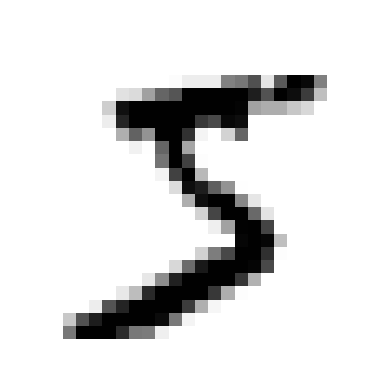

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X.iloc[0]
some_digit_image = some_digit.values.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [7]:
y.iloc[0]

'5'

In [8]:
y = y.astype(np.uint8)

The MNIST dataset is actually already split into a training set (the first 60,000
images) and a test set (the last 10,000 images):

In [9]:
X_train, X_test, y_train, y_test = X.iloc[:60000], X.iloc[60000:], y.iloc[:60000], y.iloc[60000:]

# Training a Binary Classifier

In [10]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

In [11]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

sgd_clf.predict([some_digit])

# Performance Measures

## Measuring Accuracy Using Cross-Validation

In [12]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf,X_train,y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Wow! Above 95% accuracy (ratio of correct predictions) on all cross-validation folds?
This looks amazing, doesn’t it? Well, before you get too excited, let’s look at a very
dumb classifier that just classifies every single image in the “not-5” class:

In [13]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self

    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool)

In [14]:
never_clf_5 = Never5Classifier()
cross_val_score(never_clf_5, X_train, y_train_5,cv=3,scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

That’s right, it has over 90% accuracy! This is simply because only about 10% of the
images are 5s, so if you always guess that an image is not a 5, you will be right about
90% of the time. Beats Nostradamus.

## Confusion Matrix

In [15]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

Precision (a.k.a. Positive Predictive Value):
> Out of all predicted "5"s, how many were actually correct?
> 
High Precision → Few False Positives.

Example: Your model predicted 100 images as “5” → 90 were actually “5”, Precision = 90%.

✅ Recall (a.k.a. Sensitivity or True Positive Rate):
> Out of all actual “5”s in the dataset, how many did the model catch?
 >  
 
High Recall → Few False Negatives.

Example: There are 100 actual “5”s in the data → Your model detected 80 of them, Recall = 80%.

✅ Why Both Matter:

Precision tells you how correct your positive predictions are.

Recall tells you how many positives your model catches.

Often, they’re in trade-off:

You can increase Precision by being more conservative (predict “5” only when very sure → risk missing some).

You can increase Recall by being more aggressive (predict “5” more often → risk more false alarms).

In [17]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

precision_score(y_true, y_pred)

**y_true** → The actual labels (ground truth).

**y_pred** → The model’s predictions.

In [18]:
recall_score(y_train_5,y_train_pred)

0.6511713705958311

In [19]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343847

In [20]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)  

[2164.22030239]


C:\Users\perso\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


In [21]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [22]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

How do you decide which threshold to use? First, use the cross_val_predict()
function to get the scores of all instances in the training set, but this time specify that
you want to return decision scores instead of predictions:

In [23]:
y_scores = cross_val_predict(sgd_clf,X_train, y_train_5, cv=3, method="decision_function")

With these scores, use the precision_recall_curve() function to compute precision
and recall for all possible thresholds:

In [24]:
from sklearn.metrics import precision_recall_curve

precisions,recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Finally, use Matplotlib to plot precision and recall as functions of the threshold value

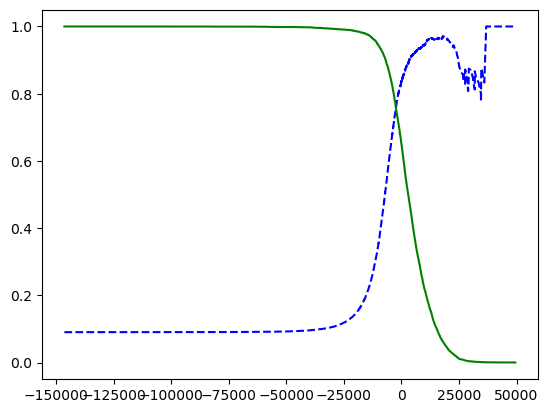

In [25]:
def plot_precision_recall_vs_threshold(precision, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Find the lowest threshold that gives me at least 90% precision:

In [26]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [27]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [28]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [29]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

## The ROC Curve

In [30]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

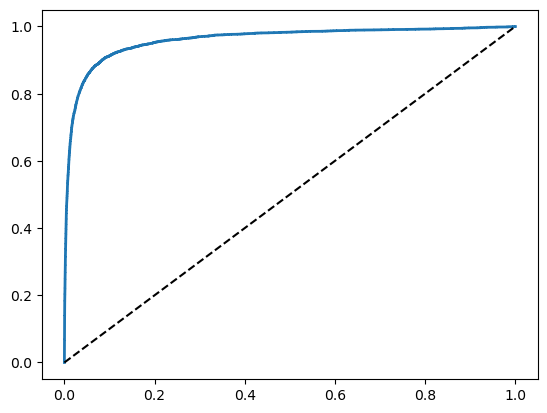

In [31]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2,label=label)
    plt.plot([0, 1], [0, 1], 'k--') 

plot_roc_curve(fpr, tpr)
plt.show()

In [32]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [33]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [34]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

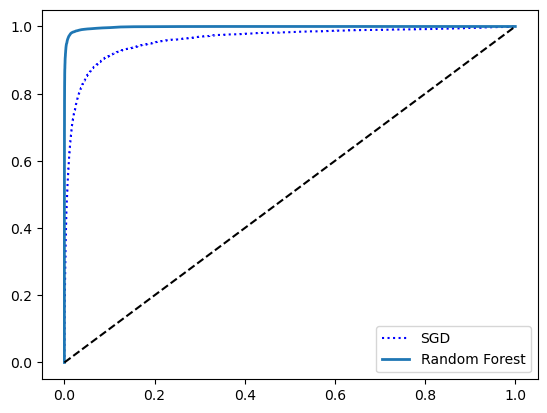

In [35]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

Comparing ROC curves: the Random Forest classifier is superior to the SGD
classifier because its ROC curve is much closer to the top-left corner, and it has a greater AUC

In [36]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

## Multiclass Classification

In [37]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

C:\Users\perso\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

In [38]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

C:\Users\perso\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [39]:
np.argmax(some_digit_scores)

5

In [40]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [41]:
#sgd_clf.fit(X_train,y_train)
#sgd_clf.predict([some_digit])

In [42]:
#sgd_clf.decision_function([some_digit])

In [43]:
from sklearn.model_selection import cross_val_score
#cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

It gets over 84% on all test folds. If you used a random classifier, you would get 10%
accuracy, so this is not such a bad score, but you can still do much better. Simply scaling
the inputs (as discussed in Chapter 2) increases accuracy above 89%:

In [ ]:
from sklearn.preprocessing import StandardScaler
#scaler =StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
#cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

## Error Analysis

In [47]:
#y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
#conf_mx = confusion_matrix(y_train, y_train_pred)
#conf_mx

In [48]:
#plt.matshow(conf_mx, cmap=plt.cm.gray)
#plt.show()

In [49]:
#row_sums = conf_mx.sum(axis=1, keepdims=True)
#norm_conf_mx = conf_mx / row_sums

In [50]:
#np.fill_diagonal(norm_conf_mx, 0)
#plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
#plt.show()

You can clearly see the kinds of errors the classifier makes. Remember that rows represent
actual classes, while columns represent predicted classes. The column for class
8 is quite bright, which tells you that many images get misclassified as 8s. However,
the row for class 8 is not that bad, telling you that actual 8s in general get properly
classified as 8s. As you can see, the confusion matrix is not necessarily symmetrical.
You can also see that 3s and 5s often get confused (in both directions).

## Multilabel Classification

In [59]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

#knn_clf = KNeighborsClassifier()
#knn_clf.fit(X_train, y_multilabel)

In [60]:
#knn_clf.predict([some_digit])

In [61]:
#y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
# f1_score(y_multilabel, y_train_knn_pred, average="macro")

## Multioutput Classification